# Comparison Between TreeValue and Tianshou Batch

In this section, we will take a look at the feature and performance of the [Tianshou Batch](https://github.com/thu-ml/tianshou) library, which is developed by Tsinghua Machine Learning Group.

Before starting the comparison, let us define some thing.

In [1]:
import torch 

_TREE_DATA_1 = {'a': 1, 'b': 2, 'x': {'c': 3, 'd': 4}}
_TREE_DATA_2 = {
    'a': torch.randn(2, 3), 
    'x': {
        'c': torch.randn(3, 4)
    },
}
_TREE_DATA_3 = {
    'obs': torch.randn(4, 84, 84),
    'action': torch.randint(0, 6, size=(1,)),
    'reward': torch.rand(1),
}

## Read and Write Operation

Reading and writing are the two most common operations in the tree data structure based on the data model (TreeValue and Tianshou Batch both belong to this type), so this section will compare the reading and writing performance of these two libraries.

### TreeValue's Get and Set

In [2]:
from treevalue import FastTreeValue

t = FastTreeValue(_TREE_DATA_2)

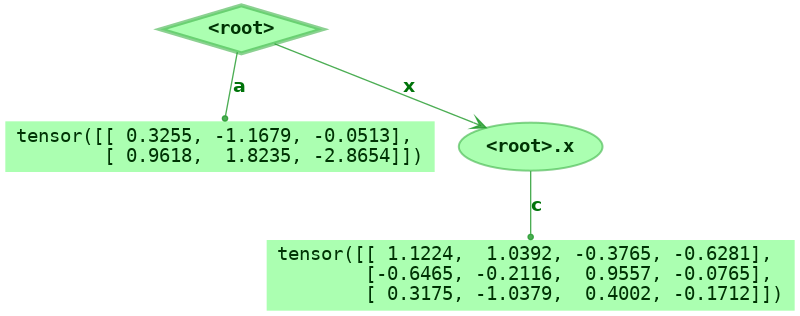

In [3]:
t

In [4]:
t.a

tensor([[ 0.3255, -1.1679, -0.0513],
        [ 0.9618,  1.8235, -2.8654]])

In [5]:
%timeit t.a

72.3 ns ± 0.0579 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


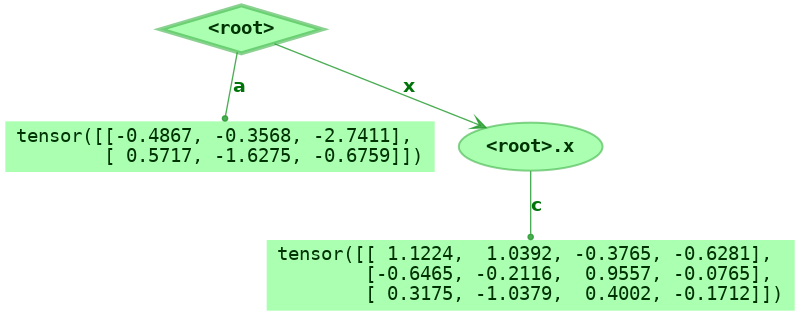

In [6]:
new_value = torch.randn(2, 3)
t.a = new_value

t

In [7]:
%timeit t.a = new_value

81.1 ns ± 0.177 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


### Tianshou Batch's Get and Set

In [8]:
from tianshou.data import Batch

b = Batch(**_TREE_DATA_2)

In [9]:
b

Batch(
    a: tensor([[ 0.3255, -1.1679, -0.0513],
               [ 0.9618,  1.8235, -2.8654]]),
    x: Batch(
           c: tensor([[ 1.1224,  1.0392, -0.3765, -0.6281],
                      [-0.6465, -0.2116,  0.9557, -0.0765],
                      [ 0.3175, -1.0379,  0.4002, -0.1712]]),
       ),
)

In [10]:
b.a

tensor([[ 0.3255, -1.1679, -0.0513],
        [ 0.9618,  1.8235, -2.8654]])

In [11]:
%timeit b.a

69.5 ns ± 0.0446 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [12]:
new_value = torch.randn(2, 3)
b.a = new_value

b

Batch(
    a: tensor([[ 1.1888,  0.6108, -0.5139],
               [-1.6417,  1.5317, -0.0349]]),
    x: Batch(
           c: tensor([[ 1.1224,  1.0392, -0.3765, -0.6281],
                      [-0.6465, -0.2116,  0.9557, -0.0765],
                      [ 0.3175, -1.0379,  0.4002, -0.1712]]),
       ),
)

In [13]:
%timeit b.a = new_value

591 ns ± 2.76 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


## Initialization

### TreeValue's Initialization

In [14]:
%timeit FastTreeValue(_TREE_DATA_1)

882 ns ± 0.883 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Tianshou Batch's Initialization

In [15]:
%timeit Batch(**_TREE_DATA_1)

11.2 µs ± 42.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Deep Copy Operation

In [16]:
import copy

### Deep Copy of TreeValue

In [17]:
t3 = FastTreeValue(_TREE_DATA_3)
%timeit copy.deepcopy(t3)

145 µs ± 772 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Deep Copy of Tianshou Batch

In [18]:
b3 = Batch(**_TREE_DATA_3)
%timeit copy.deepcopy(b3)

148 µs ± 3.31 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Stack, Concat and Split Operation

### Performance of TreeValue

In [19]:
trees = [FastTreeValue(_TREE_DATA_2) for _ in range(8)]

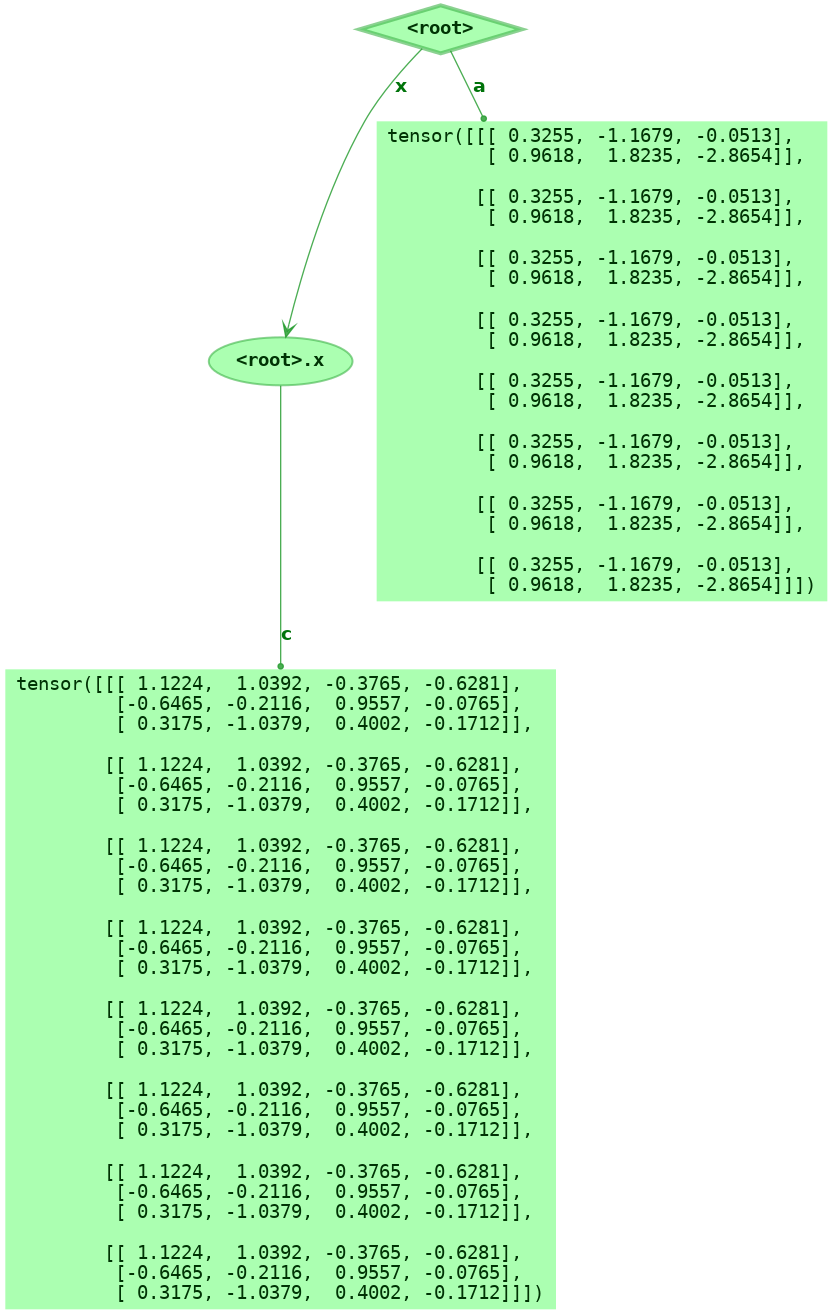

In [20]:
t_stack = FastTreeValue.func(subside=True)(torch.stack)

t_stack(trees)

In [21]:
%timeit t_stack(trees)

32.9 µs ± 90.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


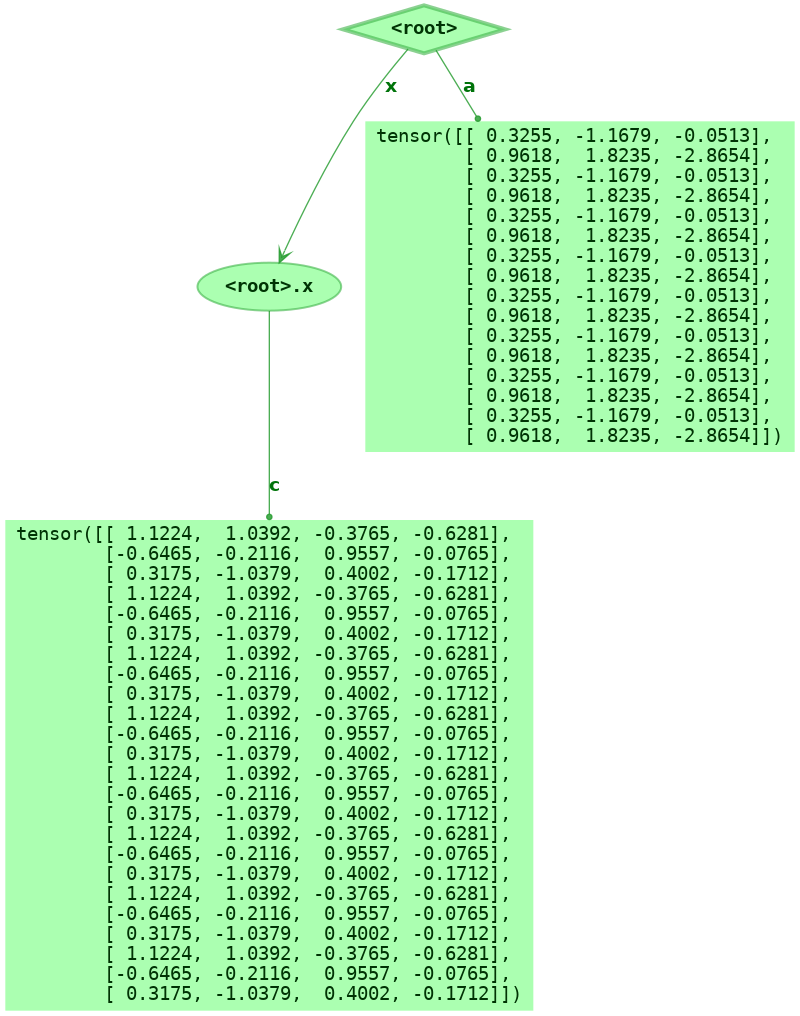

In [22]:
t_cat = FastTreeValue.func(subside=True)(torch.cat)

t_cat(trees)

In [23]:
%timeit t_cat(trees)

30.7 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
t_split = FastTreeValue.func(rise=True)(torch.split)
tree = FastTreeValue({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1),
})

%timeit t_split(tree, 1)

68.6 µs ± 65.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Performance of Tianshou Batch

In [25]:
batches = [Batch(**_TREE_DATA_2) for _ in range(8)]

Batch.stack(batches)

Batch(
    x: Batch(
           c: tensor([[[ 1.1224,  1.0392, -0.3765, -0.6281],
                       [-0.6465, -0.2116,  0.9557, -0.0765],
                       [ 0.3175, -1.0379,  0.4002, -0.1712]],
              
                      [[ 1.1224,  1.0392, -0.3765, -0.6281],
                       [-0.6465, -0.2116,  0.9557, -0.0765],
                       [ 0.3175, -1.0379,  0.4002, -0.1712]],
              
                      [[ 1.1224,  1.0392, -0.3765, -0.6281],
                       [-0.6465, -0.2116,  0.9557, -0.0765],
                       [ 0.3175, -1.0379,  0.4002, -0.1712]],
              
                      [[ 1.1224,  1.0392, -0.3765, -0.6281],
                       [-0.6465, -0.2116,  0.9557, -0.0765],
                       [ 0.3175, -1.0379,  0.4002, -0.1712]],
              
                      [[ 1.1224,  1.0392, -0.3765, -0.6281],
                       [-0.6465, -0.2116,  0.9557, -0.0765],
                       [ 0.3175, -1.0379,  0.4002, -0.1712]],

In [26]:
%timeit Batch.stack(batches)

83.4 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [27]:
Batch.cat(batches)

Batch(
    x: Batch(
           c: tensor([[ 1.1224,  1.0392, -0.3765, -0.6281],
                      [-0.6465, -0.2116,  0.9557, -0.0765],
                      [ 0.3175, -1.0379,  0.4002, -0.1712],
                      [ 1.1224,  1.0392, -0.3765, -0.6281],
                      [-0.6465, -0.2116,  0.9557, -0.0765],
                      [ 0.3175, -1.0379,  0.4002, -0.1712],
                      [ 1.1224,  1.0392, -0.3765, -0.6281],
                      [-0.6465, -0.2116,  0.9557, -0.0765],
                      [ 0.3175, -1.0379,  0.4002, -0.1712],
                      [ 1.1224,  1.0392, -0.3765, -0.6281],
                      [-0.6465, -0.2116,  0.9557, -0.0765],
                      [ 0.3175, -1.0379,  0.4002, -0.1712],
                      [ 1.1224,  1.0392, -0.3765, -0.6281],
                      [-0.6465, -0.2116,  0.9557, -0.0765],
                      [ 0.3175, -1.0379,  0.4002, -0.1712],
                      [ 1.1224,  1.0392, -0.3765, -0.6281],
                   

In [28]:
%timeit Batch.cat(batches)

154 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
batch = Batch({
    'obs': torch.randn(8, 4, 84, 84),
    'action': torch.randint(0, 6, size=(8, 1,)),
    'reward': torch.rand(8, 1)}
)

%timeit list(Batch.split(batch, 1, shuffle=False, merge_last=True))

351 µs ± 7.33 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
